In [1]:
import chess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_style("darkgrid")

In [2]:
df = pd.read_parquet('../data/data_2025_01.parquet')
df.tail()

,game_id,event,white_elo,black_elo,opening,winner,moves
9982296,9999996,Rated Blitz game,1586,1593,"Sicilian Defense: Delayed Alapin Variation, wi...",1,e2e4 c7c5 g1f3 e7e6 c2c3 d7d5 e4d5 e6d5 d2d4 c...
9982297,9999997,Rated Blitz game,2094,2106,Ruy Lopez: Berlin Defense,2,e2e4 b8c6 g1f3 e7e5 f1b5 g8f6 b5c6 b7c6 f3e5 f...
9982298,9999998,Rated Blitz game,1449,1532,Scandinavian Defense: Main Line,1,e2e4 d7d5 e4d5 d8d5 b1c3 d5a5 d2d3 c7c6 c1d2 g...
9982299,9999999,Rated Blitz game,2069,2063,Sicilian Defense: Kramnik Variation,1,e2e4 c7c5 g1f3 e7e6 c2c4 b8c6 d2d3 d7d6 b1c3 g...
9982300,10000000,Rated Blitz game,1292,1283,King's Pawn Game: Leonardis Variation,2,e2e4 e7e5 d2d3 g8f6 g1f3 b8c6 f1e2 f8e7 e1g1 d...


In [3]:
df["event"].value_counts()

event
Rated Blitz game                                                  4231136
Rated Bullet game                                                 3355083
Rated Rapid game                                                  1340401
Rated Classical game                                                56249
Rated UltraBullet game                                              46917
                                                                   ...   
Classical swiss https://lichess.org/swiss/bUvNze57                      1
Rated Rapid tournament https://lichess.org/tournament/wmyH1zNY          1
Rated Rapid tournament https://lichess.org/tournament/3XeES9oL          1
Blitz swiss https://lichess.org/swiss/UUugSTaP                          1
Rapid swiss https://lichess.org/swiss/WReDpHLY                          1
Name: count, Length: 4664, dtype: int64

In [4]:
df["opening"].value_counts()

opening
Queen's Pawn Game                                                     261820
Caro-Kann Defense                                                     185052
Van't Kruijs Opening                                                  176273
Modern Defense                                                        163143
Philidor Defense                                                      159803
                                                                       ...  
Sicilian Defense: Kan Variation, Wing Attack, Christiansen's Dream         1
Petrov's Defense: Modern Attack, Tal Gambit                                1
Scandinavian Defense: Modern Variation, Wing Gambit                        1
Italian Game: Classical Variation, Eisinger Variation                      1
King's Gambit Declined: Classical Variation, Euwe Attack                   1
Name: count, Length: 2914, dtype: int64

In [5]:
events_to_keep = [
    "Rated Bullet game",
    "Rated Blitz game",
    "Rated Rapid game",
    "Rated Classical game"
]
df = df[df["event"].isin(events_to_keep)]

top3_openings = df["opening"].value_counts().head(3).index.tolist()
df = df[df["opening"].isin(top3_openings)]

df.head()

,game_id,event,white_elo,black_elo,opening,winner,moves
2,4,Rated Blitz game,1043,1000,Queen's Pawn Game,1,d2d4 d7d5 c2c3 b8c6 g1f3 c8g4 h2h3 g4f3 e2f3 e...
6,8,Rated Blitz game,1638,1696,Queen's Pawn Game,1,d2d4 f7f6 c1f4 g7g6 e2e3 f8g7 f1d3 e7e6 c2c3 g...
13,15,Rated Blitz game,1268,1272,Van't Kruijs Opening,1,e2e3 c7c5 d2d4 c5d4 e3d4 d7d6 f1c4 e7e6 d1f3 g...
31,33,Rated Blitz game,1902,1895,Caro-Kann Defense,1,e2e4 c7c6 d1f3 d7d5 d2d3 d5e4 d3e4 g8f6 h2h3 e...
45,47,Rated Bullet game,2138,2125,Queen's Pawn Game,2,d2d4 d7d5 e2e3 c7c6 f1d3 g8f6 b1d2 c8g4 g1f3 e...


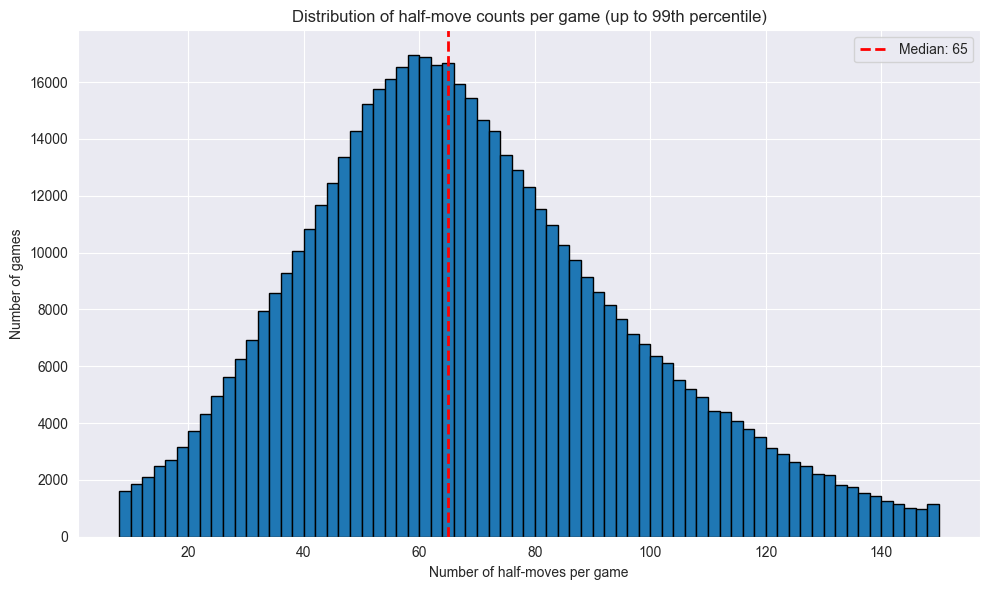

In [6]:
# Count number of half-moves (plies) per game
df["num_halfmoves"] = df["moves"].apply(lambda x: len(x.split()))
median_val = df["num_halfmoves"].median()

# Cap the histogram at the 99th percentile to avoid skew from outliers
lower_limit = int(df["num_halfmoves"].quantile(0.01))
upper_limit = int(df["num_halfmoves"].quantile(0.99))

plt.figure(figsize=(10, 6))
plt.hist(df["num_halfmoves"], bins=range(lower_limit, upper_limit, 2), edgecolor='black')
plt.axvline(median_val, color='red', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.0f}")
plt.xlabel("Number of half-moves per game")
plt.ylabel("Number of games")
plt.title("Distribution of half-move counts per game (up to 99th percentile)")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Extract positions from the first 25 half-moves of each game
records = []

for _, game in tqdm(df.iterrows(), total=len(df), desc="Processing games"):
    board = chess.Board()
    moves_arr = game["moves"].split()
    winner_flag = game["winner"]

    for idx, mv in enumerate(moves_arr):
        # Stop after 25 half-moves or if there's no next move
        if idx < 10:
            board.push_uci(mv)
            continue
        if idx >= 25 or idx + 1 >= len(moves_arr):
            break

        board.push_uci(mv)
        next_move = moves_arr[idx + 1]

        # Determine whether the player to move is on the winning side
        if (board.turn == chess.WHITE and winner_flag == 1) or (board.turn == chess.BLACK and winner_flag == 2):
            win_pov = True
        else:
            win_pov = False

        played_by = game["white_elo"] if board.turn else game["black_elo"]

        records.append({
            "fen": board.fen(),
            "next_move": next_move,
            "played_by_elo": played_by,
            "win_pov": win_pov
        })

positions_df = pd.DataFrame.from_records(records)
positions_df.head()

Processing games: 100%|██████████| 550988/550988 [05:55<00:00, 1549.45it/s]


,fen,next_move,played_by_elo,win_pov
0,r2qkbnr/ppp2ppp/2n5/3pP3/8/2P2P1P/PP3PP1/RNBQK...,c6e5,1000,False
1,r2qkbnr/ppp2ppp/8/3pn3/8/2P2P1P/PP3PP1/RNBQKB1...,c1f4,1043,True
2,r2qkbnr/ppp2ppp/8/3pn3/5B2/2P2P1P/PP3PP1/RN1QK...,f8d6,1000,False
3,r2qk1nr/ppp2ppp/3b4/3pn3/5B2/2P2P1P/PP3PP1/RN1...,f4e5,1043,True
4,r2qk1nr/ppp2ppp/3b4/3pB3/8/2P2P1P/PP3PP1/RN1QK...,d6e5,1000,False


In [8]:
# Count how often each (position, move) pair appears
positions_df["games_count"] = (
    positions_df.groupby(["fen", "next_move"])["fen"].transform("size")
)

# Keep only frequently played position-move pairs
positions_df = positions_df[positions_df["games_count"] >= 100]

n_unique = positions_df[["fen", "next_move"]].drop_duplicates().shape[0]
print(f"{n_unique} unique position–move pairs occurred at least 100 times.")

270 unique position–move pairs occurred at least 100 times.


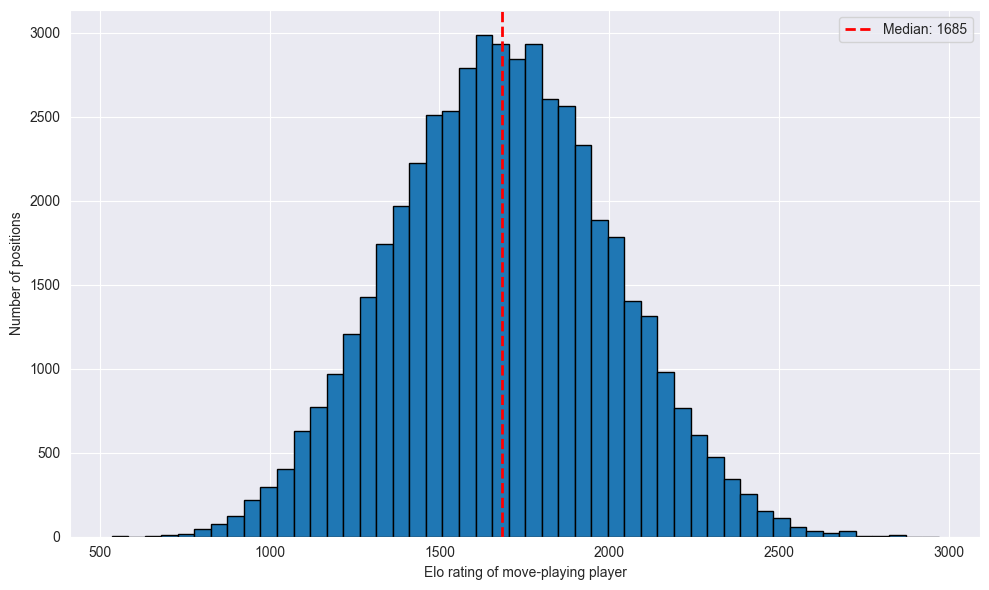

In [21]:
median_elo = positions_df["played_by_elo"].median()

plt.figure(figsize=(10, 6))
plt.hist(positions_df["played_by_elo"], bins=50, edgecolor='black')
plt.axvline(median_elo, color='red', linestyle='dashed', linewidth=2, label=f"Median: {median_elo:.0f}")
plt.xlabel("Elo rating of move-playing player")
plt.ylabel("Number of positions")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
positions_df.to_parquet("../data/positions_2025_01.parquet", index=False)
print("✅ Saved position data to 'data/positions_2025_01.parquet'")

✅ Saved position data to 'data/positions_2025_01.parquet'
